# Stable Diffusion v 1.4
Implement Stable Diffusion via Huggingface diffusers

In [1]:
# Install dependencies
%pip install -Uq -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [1]:
with open('huggingface-access-tokens.txt', 'r') as f:
    YOUR_TOKEN = f.readlines()[0]

To retrive the access tokens, refer to [this documentation](https://huggingface.co/docs/hub/security-tokens).

[Link to get token](https://huggingface.co/settings/tokens).

In [2]:
import diffusers
print("diffusers version: ", diffusers.__version__)

diffusers version:  0.3.0


In [3]:
import torch
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
%%capture
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4",
                                               revision = "fp16",
                                               torch_dtype = torch.float16,
                                               use_auth_token = YOUR_TOKEN)

{'trained_betas'} was not found in config. Values will be initialized to default values.


In [5]:
pipe.to(torch_device)

pipe.enable_attention_slicing() # attention optimization for less memory usage

In [7]:
from torch import autocast

prompt = "a photograph of an astronaut riding a horse"
with autocast(torch_device):
  image = pipe(prompt).images[0]

  0%|          | 0/51 [00:00<?, ?it/s]

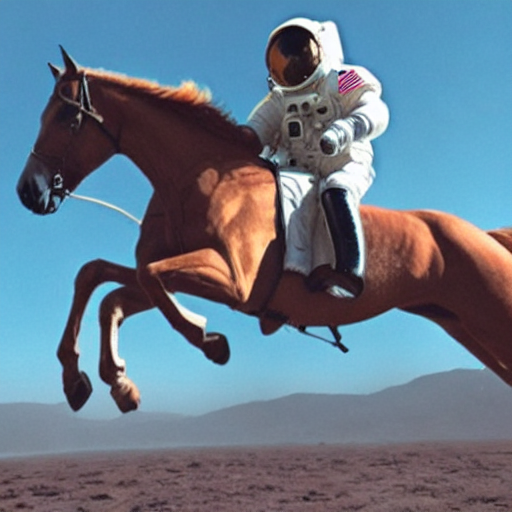

In [8]:
image

Deterministic output instead of random image generation.

In [9]:
generator = torch.Generator(torch_device).manual_seed(42)
with autocast(torch_device):
    image = pipe(prompt,
            guidance_scale = 7.5,
            generator = generator
            ).images[0]

  0%|          | 0/51 [00:00<?, ?it/s]

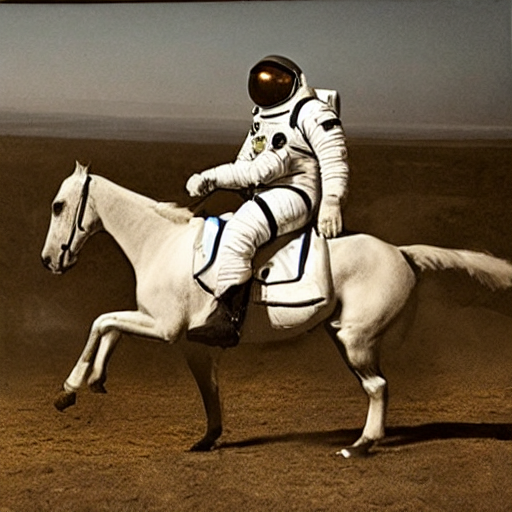

In [10]:
image